In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard

import pickle
import time
import itertools
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2
import random


2023-02-23 22:00:16.535481: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Based on https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
 
    #Add Normalization Option
    """prints pretty confusion metric with normalization option """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
 
    # print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
import os

def getPathImages(path: str, maxNb: int, classes: list[str]) -> list:
    """
    Get the path of the images and their labels. 
    The function returns a tuples with one more element than the number of classes. 
    The last element will have no class. 
    Each element contains a tuple where the first element is the name of the class 
    and the second element is the path of the images representing that class.

    Args:
    -----
        - `path` (str): Path where to look for images.
        - `classes` (list[str]): the images needed

    Returns:
    --------
        - `list`: list of tuples with the name of the class and the path of the images representing that class.
    """

    # Get all the path of jpg files in a list
    images = []
    for root, dirs, files in tqdm(os.walk(path)):
        for file in files:
            if file.endswith(".jpg"):
                images.append(os.path.join(root, file))
        l = len(images)
        if(l > maxNb):
            break
                
    # Get the path of the images of the classes indicated in the list classes
    imagesClasses = []
    for classe in classes:
        imagesClasses.append((classe, [image for image in images if classe in image]))
        
    # Get the path of the images that do not belong to the classes indicated in the list classes
    imagesNoClasses = [image for image in images if not any(classe in image for classe in classes)]
    
    # Return the list of tuples with the name of the class and the path of the images representing that class
    return imagesClasses + [("NoClass", imagesNoClasses)]


In [4]:
def getImages(pathList, classes, hPixel, wPixel, maxNb, show = 1):
    """
    Creates a list for the dataframe from the list of the 
    paths of the different images.
    Each element of the list contained a array version of
    the resized image.

    Args:
    -----
        - `pathList`: list of the paths to images.
        - `classes`: list of possible classes
        - `hPixel`: number of pixel in the height of the final images
        - `wPixel`: number of pixel in the width of the final images
        - `maxNb`: list for the number of elements for each class (also NoClass)

    Returns:
    --------
        Retunrs a list of classified images
    """


    data = []
    classes = classes + ['NoClass']

    for i in range(len(classes)):
        list_c = pathList[i]
        cat_c = list_c[0]
        paths = list_c[1]
        class_nb = i
        count = 0
        random.shuffle(paths)   #si soucis-ici
            
        for path_c in tqdm(paths):
            img = cv2.imread(path_c)

            if(len(data)==0 and show):
                plt.imshow(img)
                plt.show()
            
            try:
                new_img = cv2.resize(img, (hPixel, wPixel))
            except:
                continue

            if(len(data)==0 and show):
                plt.imshow(new_img)
                plt.show()        

            data.append([new_img, class_nb])
            count += 1
            if(count >= maxNb[i]):
                break

    return data

## Get images

442it [00:00, 1437.50it/s]


/scratch/users/mdelabrassinne/Database/england_epl/2014-2015/2015-02-21_-_18-00_Chelsea_1_-_1_Burnley/sequences/Corner/1/1.jpg


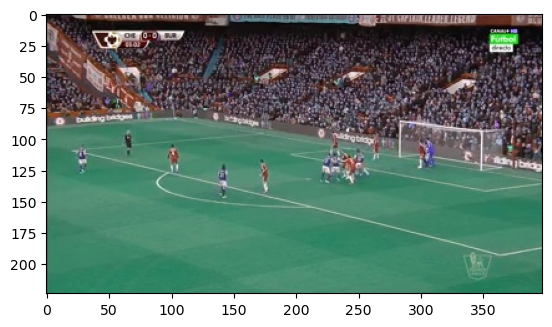

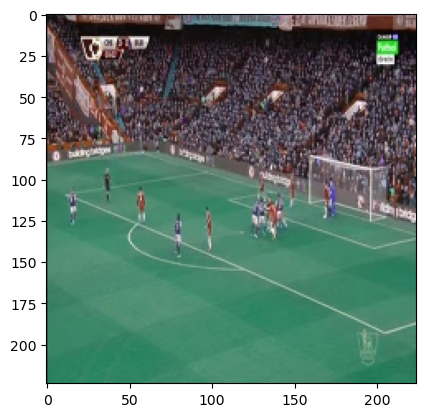

In [5]:
direct = "/scratch/users/mdelabrassinne/Database/"
paths = getPathImages(direct, 10000, ["Corner"])
print(paths[0][1][0])

img = cv2.imread(paths[0][1][0])
plt.imshow(img)
plt.show()

img2 = cv2.resize(img, (224, 224))
plt.imshow(img2)
plt.show()

4371it [00:02, 1507.40it/s]
4368it [00:02, 1514.08it/s]
4368it [00:02, 1559.34it/s]
4389it [00:02, 1563.13it/s]
4389it [00:02, 1591.29it/s]
4350it [00:02, 1548.84it/s]
4331it [00:02, 1544.64it/s]
4331it [00:02, 1591.50it/s]


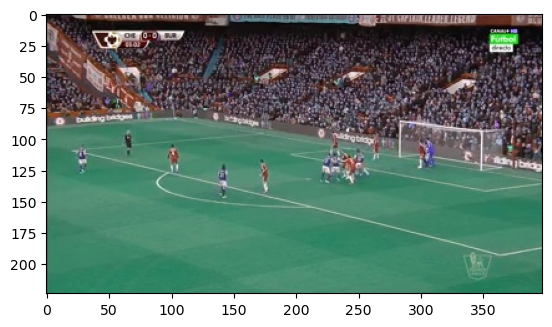

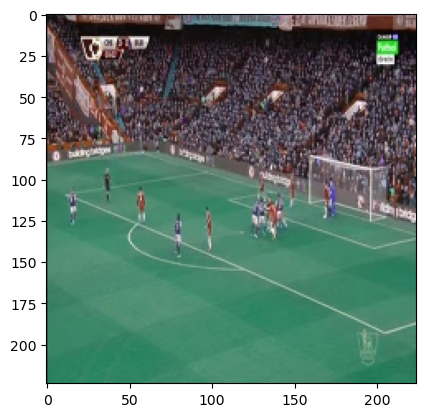

In [6]:
direct = "/scratch/users/mdelabrassinne/Database/"
matches = os.listdir(direct)[:-5]
matchTest = os.listdir(direct)[-5:-3]
classes = ["Corner"]
nClasses = len(classes)+1  #also take into account noClass
count = 0

for match in matches:
    p = os.path.join(direct, match)
    if(count == 0):
        paths=getPathImages(p, 100000, classes)
    else:
        for i in range(nClasses):
            paths[i][1].extend(getPathImages(p, 100000, classes)[i][1])
    count += 1

count = 0
for match in matchTest:
    p = os.path.join(direct, match)
    if(count == 0):
        pathsTest=getPathImages(p, 100000, classes)
    else:
        for i in range(nClasses):
            pathsTest[i][1].extend(getPathImages(p, 100000, classes)[i][1])
    count += 1
    

img = cv2.imread(paths[0][1][0])
plt.imshow(img)
plt.show()

img2 = cv2.resize(img, (224, 224))
plt.imshow(img2)
plt.show()

In [7]:
direct = "/scratch/users/mdelabrassinne/Database/"
matches = os.listdir(direct)[:-5]
print(matches)
print("")
matchTest = os.listdir(direct)[-5:-3]
print(matchTest)

['england_epl', 'europe_uefa-champions-league', 'france_ligue-1']

['germany_bundesliga', 'italy_serie-a']


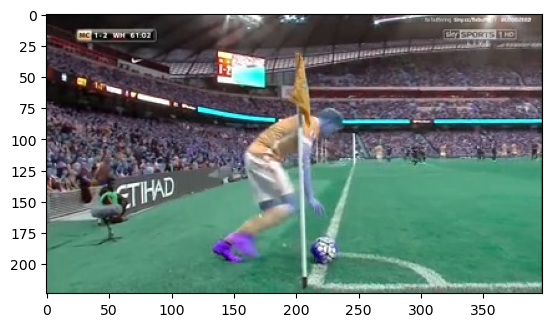

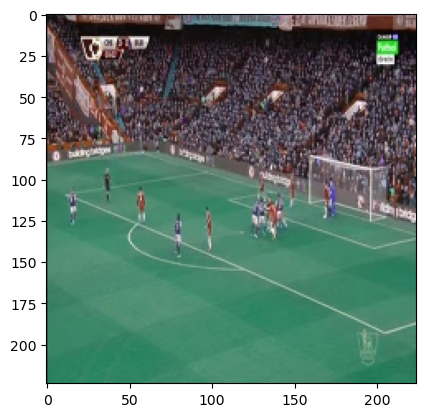

In [8]:
img = cv2.imread(paths[0][1][1580])
plt.imshow(img)
plt.show()

plt.imshow(img2)
plt.show()

  0%|          | 0/14450 [00:00<?, ?it/s]

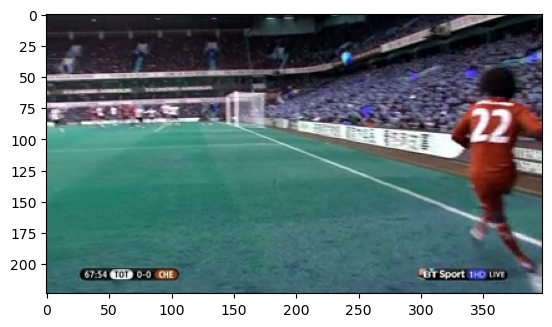

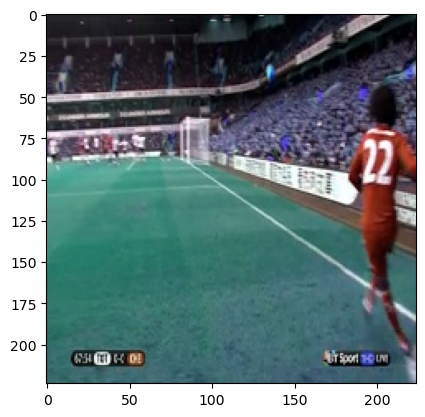

  0%|          | 0/7225 [00:00<?, ?it/s]

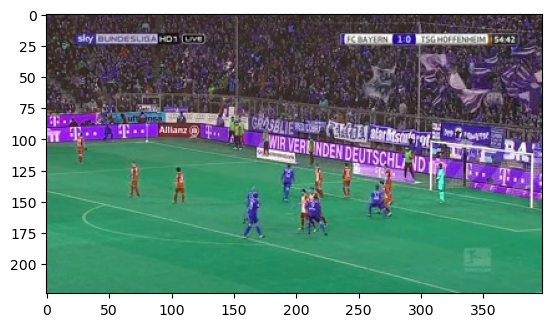

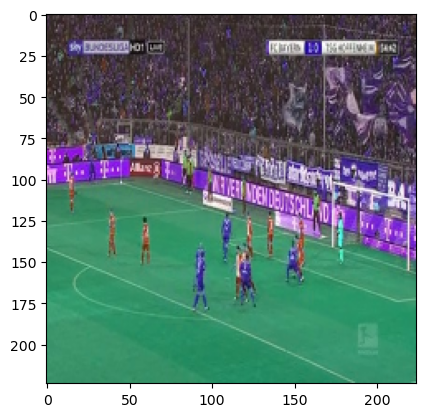

  3%|▎         | 4999/192822 [00:46<29:05, 107.62it/s]


In [10]:
pathList = paths
classes = ["Corner"]
vPixel = 224
hPixel = 224
maxNb = [10000, 10000]

data = getImages(pathList, classes, vPixel, hPixel,maxNb)
random.shuffle(data)

#trainingData, testData = train_test_split(data, test_size= 0.2)     #last line added
#print(len(testData))

dataTest = getImages(pathsTest, classes, vPixel, hPixel,[10000, 10000])
random.shuffle(dataTest)

In [11]:
del paths
del pathList
del pathsTest

1


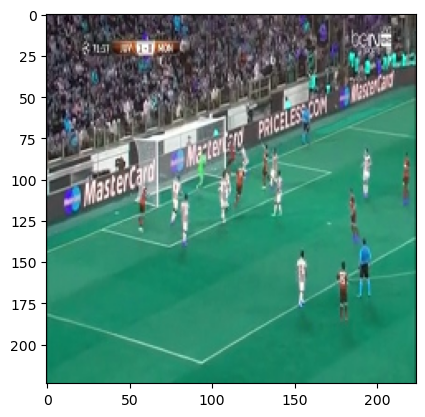

In [12]:
#just to check

nb = 1
plt.imshow(data[nb][0])
print(data[nb][1])

1


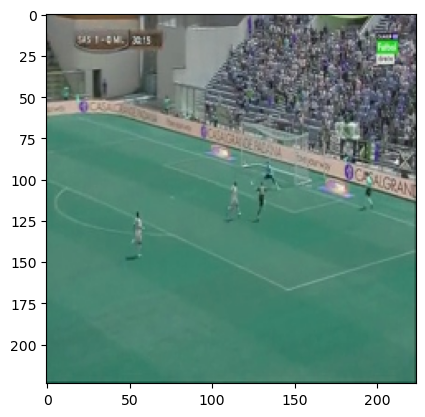

In [13]:
#just to check

nb = 0
plt.imshow(dataTest[nb][0])
print(dataTest[nb][1])

In [14]:
X = []
y = []


for features,label in tqdm(data):

    X.append(features)  # prob a la 4273 eme, 3931
    y.append(label)


X = np.array(X).reshape(-1, vPixel, hPixel, 3)
y = np.array(y)

100%|██████████| 10000/10000 [00:00<00:00, 1805710.35it/s]


In [15]:
del data
del dataTest

In [32]:
#dir()

In [49]:
print(X.shape)

(10000, 224, 224, 3)


In [ ]:
# save dataframe

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [14]:
# get dataframe if already computed before

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

## CNN

In [16]:
# 1) normalize inputs

X = X/255.0

In [17]:
print(X)

[[[[0.15294118 0.29019608 0.25098039]
   [0.16470588 0.30196078 0.2627451 ]
   [0.14509804 0.28235294 0.24313725]
   ...
   [0.40784314 0.14901961 0.2627451 ]
   [0.40392157 0.14901961 0.25098039]
   [0.40392157 0.14901961 0.25098039]]

  [[0.3254902  0.49411765 0.44313725]
   [0.34509804 0.51372549 0.4627451 ]
   [0.33333333 0.50196078 0.45098039]
   ...
   [0.61960784 0.37647059 0.49411765]
   [0.61568627 0.37647059 0.48627451]
   [0.61960784 0.38039216 0.49019608]]

  [[0.2627451  0.48627451 0.40392157]
   [0.29019608 0.51372549 0.43137255]
   [0.28235294 0.50588235 0.42352941]
   ...
   [0.56470588 0.35294118 0.47058824]
   [0.56078431 0.34901961 0.46666667]
   [0.56470588 0.35294118 0.46666667]]

  ...

  [[0.05098039 0.39215686 0.25098039]
   [0.05098039 0.39215686 0.25098039]
   [0.05490196 0.38431373 0.24705882]
   ...
   [0.08627451 0.41176471 0.28627451]
   [0.07843137 0.41176471 0.28627451]
   [0.07058824 0.41176471 0.28235294]]

  [[0.05098039 0.39215686 0.25098039]
   [0.0

In [18]:
print(y)

[1 1 0 ... 1 1 0]


In [19]:
#tf.keras.initializers.VarianceScaling(
#    scale=1.0,
#    mode='fan_in',
#    distribution='truncated_normal',
#    seed=None
#)

In [ ]:
# 2) model (si vous voulez, j'ai un code qui boucle sur plusieurs architectures)

dense_layer = 3
layer_size = 64
conv_layer = 5


NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
print(NAME)

model = Sequential()

model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))  
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

for l in range(conv_layer-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())                                   # first layer has to have a flatten before classification

for _ in range(dense_layer):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

model.compile(loss='binary_crossentropy',               # change to categorical_crossentropy when more than 2 classes
                optimizer='adam',
                metrics=['accuracy'],
                )

model.summary()

hist = model.fit(X, y,
            batch_size=32,
            epochs=50,
            callbacks=[tensorboard])

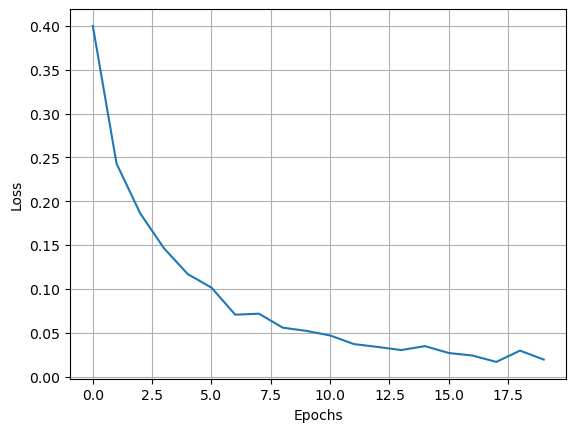

<Figure size 640x480 with 0 Axes>

In [18]:
ax = plt.axes()
fig = plt.figure()
ax.grid()
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.plot(hist.history['loss'])
plt.show()

In [49]:
#model.save('model_v1.h5')

In [15]:
#model = tf.keras.models.load_model('model_v1.h5')

2023-02-23 10:34:12.463084: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-23 10:34:12.464797: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-23 10:34:12.526864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-02-23 10:34:12.526900: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-23 10:34:12.783884: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-23 10:34:12.784019: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

In [28]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
model.summary()

In [11]:
X_test = []
y_test = []


for features,label in tqdm(dataTest):

    X_test.append(features)  # prob a la 4273 eme, 3931
    y_test.append(label)


X_test = np.array(X_test).reshape(-1, vPixel, hPixel, 3)
y_test = np.array(y_test)

100%|██████████| 10000/10000 [00:00<00:00, 1450362.74it/s]


In [12]:
print(X_test.shape)

(10000, 224, 224, 3)


In [ ]:
del X
del data

In [23]:
print(X_test.shape)

(10000, 224, 224, 3)


In [ ]:
lim = 6000

In [ ]:
X_test = X_test[:lim]/255
y_test = y_test[:lim]

In [ ]:
pred = np.round(model.predict(X_test))
err = np.sum(np.abs(pred.T - y_test))/len(pred)
print(err)

In [1]:
cl = ["Corner", "NoClass"]
conf_matrix = confusion_matrix(y_test, np.round(pred))
plot_confusion_matrix(conf_matrix, cl, normalize=True)

NameError: name 'confusion_matrix' is not defined

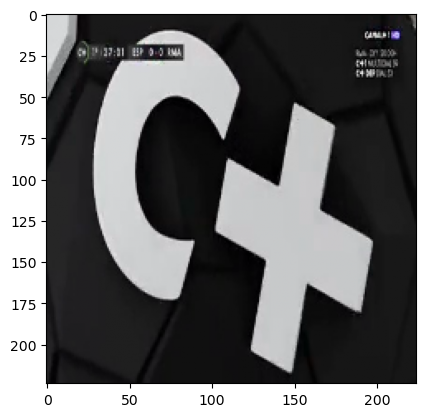

In [101]:
ind1 = np.where(y_test == 0) 
ind2 = np.where(np.round(pred) == 1)    #predi rien
ind = np.intersect1d(ind1, ind2)

plt.imshow(X_test[ind[7]])

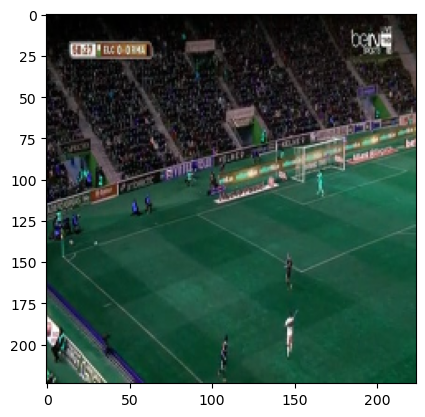

In [90]:
ind1 = np.where(y_test == 1) 
ind2 = np.where(np.round(pred) == 0)      #predi corner
ind = np.intersect1d(ind1, ind2)

nb = 10

plt.imshow(X_test[ind[nb]])
plt.show()


In [28]:
pred = np.round(model.predict(X_test), 2)

In [140]:
# 2) model (si vous voulez, j'ai un code qui boucle sur plusieurs architectures)

dense_layer = 2
layer_size = 32
conv_layer = 5


NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
print(NAME)

model = Sequential()

model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))          # first layer has to have a flatten
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

for l in range(conv_layer-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

for _ in range(dense_layer):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

model.compile(loss='binary_crossentropy',               # change to categorical_crossentropy when more than 2 classes
                optimizer='adam',
                metrics=['accuracy'],
                )

model.summary()

hist = model.fit(X, y,
            batch_size=32,
            epochs=10,
            validation_split=0.3,
            # validation_data=(validation_data, validation_labels))   # if want to use another method
            callbacks=[tensorboard])

5-conv-32-nodes-2-dense-1676804099
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 118, 118, 32)      896       
_________________________________________________________________
activation_31 (Activation)   (None, 118, 118, 32)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 57, 57, 32)        9248      
_________________________________________________________________
activation_32 (Activation)   (None, 57, 57, 32)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D) 

2023-02-19 11:54:59.592744: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-02-19 11:54:59.592792: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-02-19 11:54:59.592918: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2023-02-19 11:54:59.592945: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/10
 11/350 [..............................] - ETA: 5s - loss: 0.6921 - accuracy: 0.4914 

2023-02-19 11:55:03.612018: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-02-19 11:55:03.612061: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-02-19 11:55:03.612138: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2023-02-19 11:55:03.678849: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-02-19 11:55:03.680568: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-02-19 11:55:03.681753: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-02-19 11:55:03.684949: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/5-conv-32-nodes-2-dense-1676804099/train/plug

350/350 [==============================] - 5s 13ms/step - loss: 0.5847 - accuracy: 0.6861 - val_loss: 0.4364 - val_accuracy: 0.7996
Epoch 2/10
350/350 [==============================] - 3s 8ms/step - loss: 0.4348 - accuracy: 0.8009 - val_loss: 0.3655 - val_accuracy: 0.8365
Epoch 3/10
350/350 [==============================] - 3s 8ms/step - loss: 0.3517 - accuracy: 0.8429 - val_loss: 0.3586 - val_accuracy: 0.8417
Epoch 4/10
350/350 [==============================] - 3s 8ms/step - loss: 0.3433 - accuracy: 0.8493 - val_loss: 0.3348 - val_accuracy: 0.8521
Epoch 5/10
350/350 [==============================] - 3s 8ms/step - loss: 0.3076 - accuracy: 0.8696 - val_loss: 0.3110 - val_accuracy: 0.8656
Epoch 6/10
350/350 [==============================] - 3s 8ms/step - loss: 0.2919 - accuracy: 0.8742 - val_loss: 0.3204 - val_accuracy: 0.8635
Epoch 7/10
350/350 [==============================] - 3s 8ms/step - loss: 0.2735 - accuracy: 0.8872 - val_loss: 0.3304 - val_accuracy: 0.8604
Epoch 8/10
350/3

2014
986


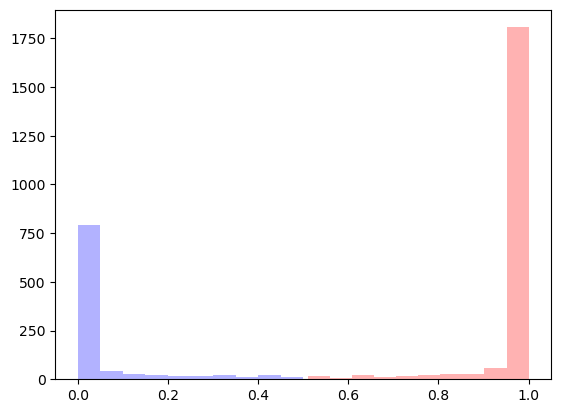

<Figure size 640x480 with 0 Axes>

In [29]:
ax = plt.axes()
fig = plt.figure()

pBis = np.round(pred)

cornind = pBis == 0
nInd = pBis == 1
print(np.sum(nInd))
print(np.sum(cornind))
ax.hist(pred[cornind], color = 'blue', alpha = 0.3, label = "Corner")
ax.hist(pred[nInd], color='red', alpha = 0.3, label = "No class")
plt.show()